In [ ]:
Jagung Pipilan Kering

Data Jagung Pipilan Kering (Target: Wlingi_Jagung Pipilan Kering) berhasil digabungkan. Ukuran data: 320

  UJI STASIONERITAS (ADF TEST) - Wlingi_Jagung Pipilan Kering
Statistic Uji ADF: -1.4553
p-value: 0.5555125299046383
Critical Values:
	1%: -3.4510
	5%: -2.8706
	10%: -2.5716

Kesimpulan: Data TIDAK STASIONER. (Gagal menolak hipotesis nol)
Statistic Uji ADF: -17.7764
p-value: 3.291083972934036e-30
Critical Values:
	1%: -3.4511
	5%: -2.8707
	10%: -2.5716

Kesimpulan: Data adalah STASIONER. (Tolak hipotesis nol)

--- Visualisasi Data Asli (Sebelum Differencing) ---
Plot ACF/PACF Data Asli telah disimpan sebagai 'analisis_jagung_ACF_PACF_RAW.png'

--- Visualisasi Data Stasioner (Setelah Differencing) ---

Visualisasi data stasioner telah disimpan sebagai 'analisis_jagung_stationary.png'


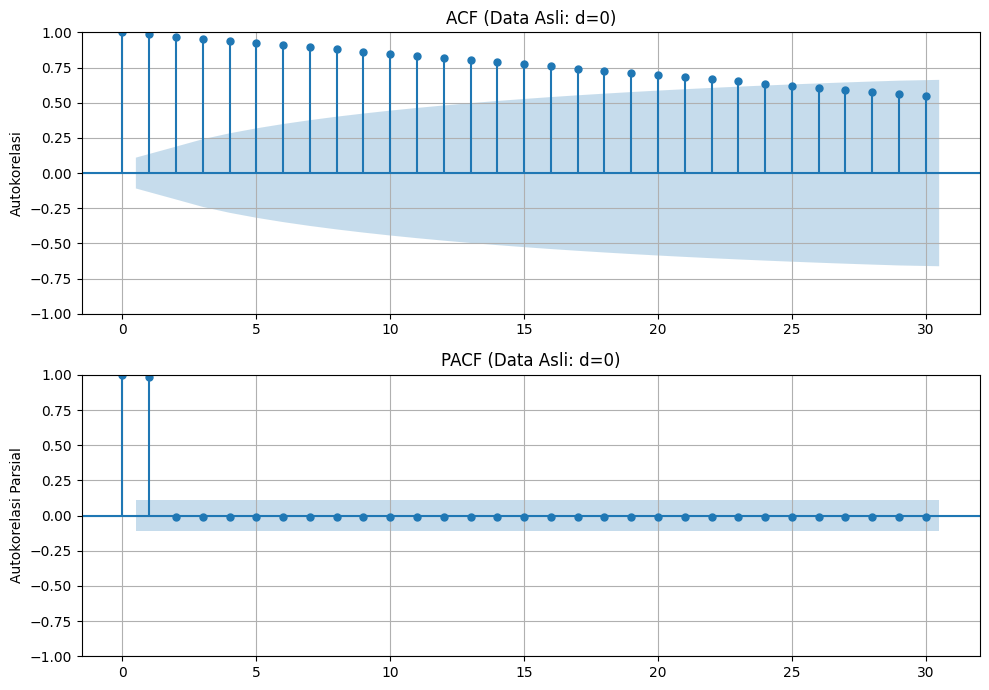

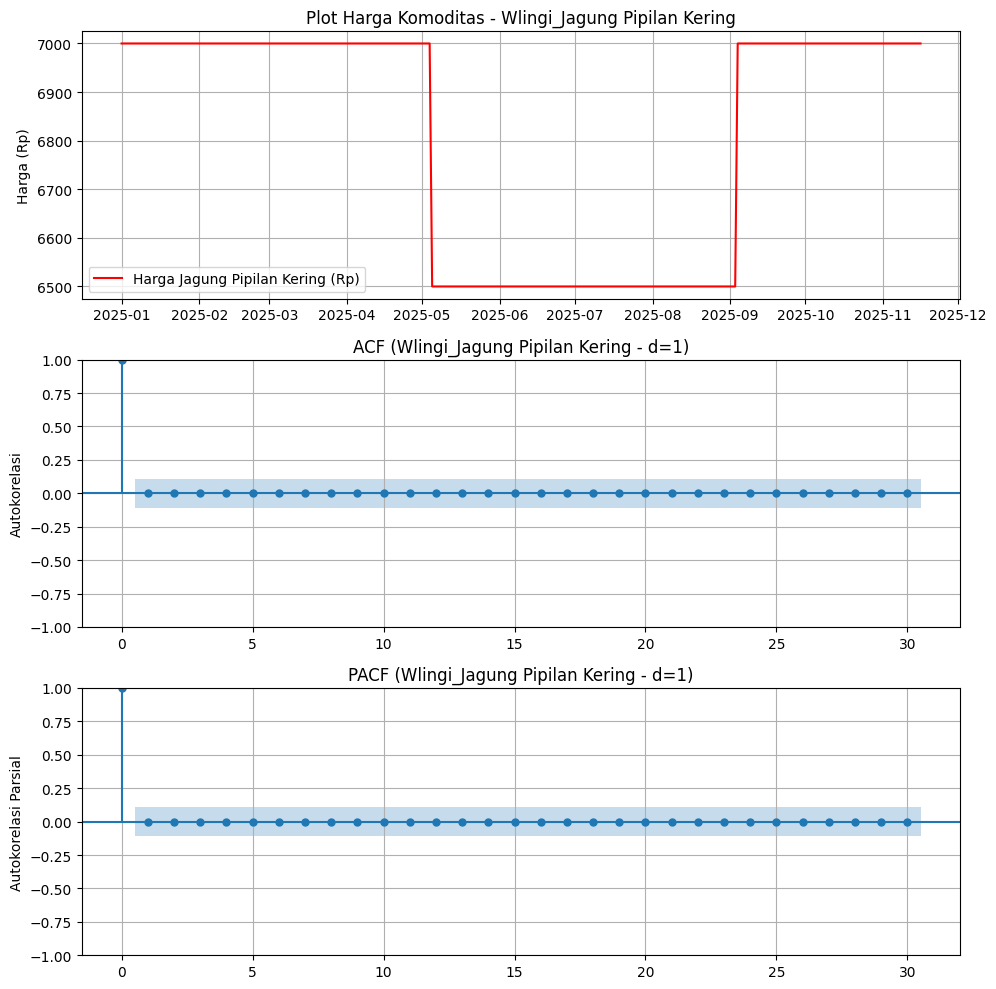

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import re 

warnings.filterwarnings("ignore")

# ==============================================================================
# 1. LOAD DAN PEMBERSIHAN DATA
# ==============================================================================
def load_and_clean_data(file_path, market_name):
    """Memuat, membersihkan, dan mengatur indeks tanggal."""
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    
    # Konversi kolom 'Tanggal' ke datetime
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce')
    df.set_index('Tanggal', inplace=True)
    
    # Cleaning dan Konversi Harga
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[Rp\s,.]', '', regex=True)
            df[col] = df[col].replace({'': np.nan, 'nan': np.nan}) 
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.interpolate(method='linear')
    df = df.add_prefix(f'{market_name}_')
    return df

# Memuat data dari kedua pasar
df_lodoyo = load_and_clean_data('/PA/dataset/pasar-lodoyo.csv', 'Lodoyo')
df_wlingi = load_and_clean_data('/PA/dataset/pasar-wlingi.csv', 'Wlingi')

# Menggabungkan data berdasarkan indeks Tanggal
df_merged = pd.merge(df_wlingi, df_lodoyo, left_index=True, right_index=True, how='inner')

# PILIH KOMODITAS: Minyak Goreng MINYAKITA
target_col = 'Wlingi_Jagung Pipilan Kering'
exog_col = 'Lodoyo_Jagung Pipilan Kering'
data_cr = df_merged[target_col].astype(float).dropna()

print(f"Data Jagung Pipilan Kering (Target: {target_col}) berhasil digabungkan. Ukuran data: {len(data_cr)}")

# ==============================================================================
# 2. UJI STASIONERITAS (ADF TEST) pada Target
# ==============================================================================
print("\n" + "="*45)
print(f"  UJI STASIONERITAS (ADF TEST) - {target_col}")
print("="*45)

def adf_test(series):
    """Fungsi untuk menjalankan dan mencetak hasil ADF Test."""
    if series.max() == series.min():
        print("Nilai input konstan setelah cleaning/interpolasi. Uji ADF tidak mungkin.")
        return 0
        
    result = adfuller(series, autolag='AIC')
    print(f'Statistic Uji ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("\nKesimpulan: Data adalah STASIONER. (Tolak hipotesis nol)")
        return 0
    else:
        print("\nKesimpulan: Data TIDAK STASIONER. (Gagal menolak hipotesis nol)")
        # Kita akan coba differencing tingkat 1
        d_val = adf_test(series.diff().dropna())
        return d_val + 1

d_cr = adf_test(data_cr)

# ==============================================================================
# 3. VISUALISASI DERET WAKTU DAN AUTOKORELASI
# ==============================================================================

# Data setelah differencing (data yang STASIONER)
data_plot_stationary = data_cr.diff(d_cr).dropna() if d_cr > 0 else data_cr
plot_title_stationary = f'({target_col} - d={d_cr})'

# --- A. PLOT DATA ASLI (Sebelum Differencing) ---
print("\n--- Visualisasi Data Asli (Sebelum Differencing) ---")
fig_raw, axes_raw = plt.subplots(2, 1, figsize=(10, 7))
plt.subplots_adjust(hspace=0.4)

# Plot Autokorelasi (ACF) Data Asli
plot_acf(data_cr, ax=axes_raw[0], lags=30, title=f'ACF (Data Asli: d=0)')
axes_raw[0].grid(True)
axes_raw[0].set_ylabel('Autokorelasi')

# Plot Autokorelasi Parsial (PACF) Data Asli
plot_pacf(data_cr, ax=axes_raw[1], lags=30, title=f'PACF (Data Asli: d=0)')
axes_raw[1].grid(True)
axes_raw[1].set_ylabel('Autokorelasi Parsial')

plt.tight_layout()
plt.savefig('analisis_jagung_ACF_PACF_RAW.png')
print("Plot ACF/PACF Data Asli telah disimpan sebagai 'analisis_jagung_ACF_PACF_RAW.png'")


# --- B. PLOT DATA STASIONER (Setelah Differencing) ---
print("\n--- Visualisasi Data Stasioner (Setelah Differencing) ---")
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

# Plot Deret Waktu Asli
axes[0].plot(data_cr, label='Harga Jagung Pipilan Kering (Rp)', color='red')
axes[0].set_title(f'Plot Harga Komoditas - {target_col}')
axes[0].set_ylabel('Harga (Rp)')
axes[0].grid(True)
axes[0].legend()

# Plot Autokorelasi (ACF) Data Stasioner
plot_acf(data_plot_stationary, ax=axes[1], lags=30, title=f'ACF {plot_title_stationary}')
axes[1].grid(True)
axes[1].set_ylabel('Autokorelasi')

# Plot Autokorelasi Parsial (PACF) Data Stasioner
plot_pacf(data_plot_stationary, ax=axes[2], lags=30, title=f'PACF {plot_title_stationary}')
axes[2].grid(True)
axes[2].set_ylabel('Autokorelasi Parsial')

plt.tight_layout()
plt.savefig('analisis_jagung_sederhana_stationary.png')
print("\nVisualisasi data stasioner telah disimpan sebagai 'analisis_jagung_stationary.png'")

In [6]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. SETUP ---
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

def ensure_dir(directory):
    if not os.path.exists(directory): os.makedirs(directory)

# --- 2. FUNGSI CLEANING SUPER KETAT ---
def clean_super_strict(file_path, market_name):
    print(f"--- Memproses {market_name} ---")
    df = pd.read_csv(file_path, dtype=str) # Baca semua sebagai string dulu
    
    # Cari kolom tanggal
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower()), None)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    
    for col in df.columns:
        if re.search(r'harga|beras|telur|minyak|cabe|jagung', col, re.IGNORECASE):
            # Ambil contoh data mentah
            print(f"Contoh mentah {col}: {df[col].iloc[0]} s/d {df[col].iloc[-1]}")
            
            # HAPUS "Rp", " ", dan "," (koma dianggap desimal dibuang)
            # Logika: Ambil angka sebelum koma saja
            df[col] = df[col].astype(str).apply(lambda x: x.split(',')[0]) 
            # Hapus titik (pemisah ribuan)
            df[col] = df[col].str.replace('.', '', regex=False)
            # Hapus karakter non-angka
            df[col] = df[col].str.replace(r'\D', '', regex=True)
            
            # Convert ke Float
            df[col] = pd.to_numeric(df[col], errors='coerce')
                
            # Interpolasi
            df[col] = df[col].interpolate().fillna(method='ffill').fillna(method='bfill')
            
            print(f"-> Hasil bersih {col}: Min={df[col].min()}, Max={df[col].max()}")

    return df.add_prefix(f'{market_name}_')

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# --- 3. EKSEKUSI ---
file_wlingi = '/PA/dataset/pasar-wlingi.csv'
file_lodoyo = '/PA/dataset/pasar-lodoyo.csv'
OUT_DIR = 'outputs_debug_fix'
ensure_dir(OUT_DIR)

# A. Load & Clean
df_wlingi = clean_super_strict(file_wlingi, 'Wlingi')
df_lodoyo = clean_super_strict(file_lodoyo, 'Lodoyo')
df_merged = df_wlingi.join(df_lodoyo, how='inner')

target_col = 'Wlingi_Jagung Pipilan Kering'
exog_col = 'Lodoyo_Jagung Pipilan Kering'
data = df_merged[[target_col, exog_col]].dropna()

print(f"\nDATA SIAP. Total Baris: {len(data)}")
print(data.head())

# B. Split & Scale
train_size = int(len(data) * 0.6) 
train_values = data.iloc[:train_size].values.astype('float32')
test_values = data.iloc[train_size:].values.astype('float32')

print("\n--- CEK SCALING ---")
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

print(f"Train Scaled Max: {train_scaled.max()} (Harus 1.0)")
print(f"Test Scaled Max : {test_scaled.max()} (Harus sekitar 1.0, JANGAN RIBUAN)")

if test_scaled.max() > 5:
    print("⛔ STOP! Test Data masih bocor (nilai terlalu besar).")
else:
    print("✅ DATA AMAN. Lanjut Training...")

--- Memproses Wlingi ---
Contoh mentah Beras Premium: 14600 s/d 14900
-> Hasil bersih Beras Premium: Min=14600, Max=15000
Contoh mentah Beras Medium: 12500 s/d 12500
-> Hasil bersih Beras Medium: Min=12500, Max=13500
Contoh mentah Minyak Goreng Curah: 16000 s/d 16000
-> Hasil bersih Minyak Goreng Curah: Min=16000, Max=16000
Contoh mentah Minyak Goreng Kemasan Premium: 18500 s/d 20000
-> Hasil bersih Minyak Goreng Kemasan Premium: Min=18500, Max=20000
Contoh mentah Minyak Goreng Kemasan Sederhana: 17500 s/d 18500
-> Hasil bersih Minyak Goreng Kemasan Sederhana: Min=17500, Max=18500
Contoh mentah Minyak Goreng MINYAKITA: 16000 s/d 15700
-> Hasil bersih Minyak Goreng MINYAKITA: Min=15700, Max=16000
Contoh mentah Telur Ayam Ras: 30000 s/d 28000
-> Hasil bersih Telur Ayam Ras: Min=24000, Max=30000
Contoh mentah Telur Ayam Kampung: 45000 s/d 45000
-> Hasil bersih Telur Ayam Kampung: Min=45000, Max=45000
Contoh mentah Jagung Pipilan Kering: 7000 s/d 7000
-> Hasil bersih Jagung Pipilan Kering:

## ARIMAX

In [5]:
import os
import re
import pickle
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)


# -------------------------
# Config
# -------------------------
FILE_WLINGI = "/PA/dataset/pasar-wlingi.csv"   # <-- file path yang sudah kamu upload
FILE_LODOYO = "/PA/dataset/pasar-lodoyo.csv"   # <-- file path yang sudah kamu upload
OUT_DIR = "outputs_arimax_jagung_fixed"
ensure = lambda d: os.makedirs(d, exist_ok=True)
ensure(OUT_DIR)

# Ganti sesuai kebutuhan:
TARGET_BASE_NAME = "Jagung Pipilan Kering"   # kolom target di file CSV (tanpa prefix)
# Jika berbeda, sesuaikan nama ini

# Model hyperparams (default yang direkomendasikan)
P_RANGE = [0, 1, 2]   # akan dicoba untuk grid search kecil
D = 1                 # jika memakai differencing pada y
Q_RANGE = [0, 1, 2]      # dicoba
TREND = 'c'           # gunakan intercept (constant) untuk harga pangan
TEST_SIZE_FRAC = 0.4

# Pilihan penting:
DIFFERENCE_EXOG = True    # jika True -> pakai ΔX ketika d>0 (recommended)
EXOG_LAGS = [1]           # daftar lag eksogen yang akan dicoba/ditambahkan (0 = contemporaneous)
# contoh: [0,1] artinya gunakan X_t dan X_{t-1}. Jika hanya [1], maka hanya X_{t-1}.

FORECAST_HORIZONS = [3, 7, 14, 30]
MAX_FORECAST_DAYS = max(FORECAST_HORIZONS)

# -------------------------
# Util functions
# -------------------------
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def clean_and_prefix_data(file_path, market_name):
    # Memuat CSV, parse tanggal dd/mm/YYYY, set index
    df = pd.read_csv(file_path)
    # cari kolom tanggal
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'tgl' in c.lower() or 'date' in c.lower()), None)
    if date_col is None:
        raise ValueError(f"Tidak menemukan kolom tanggal di {file_path}")
    # bersihkan nama kolom dari spasi di ujung/kiri
    df.columns = df.columns.str.strip()
    # parse tanggal (format dd/mm/yyyy)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).copy()
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    # sanitasi ringan kolom harga: hapus whitespace, 'Rp' jika ada, ubah ke numeric
    for col in df.columns:
        # skip if already numeric
        if df[col].dtype == object:
            s = df[col].astype(str).str.strip().str.replace('Rp', '', regex=False).str.replace(' ', '', regex=False)
            # if contains comma and dot we try to normalize (but dataset kamu integer jadi ini safe)
            s = s.str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(s, errors='coerce')
    # fill small gaps by interpolation then bfill/ffill
    df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    df = df.add_prefix(market_name + "_")
    return df

def prepare_exog_matrix(exog_series, exog_lags, difference_exog=False):
    """
    exog_series: pd.Series (indexed by date)
    exog_lags: list of integers (e.g. [0,1] includes contemporaneous and lag1)
    difference_exog: jika True dan exog_series harus di-diff sebelum membuat lags
    """
    df = pd.DataFrame(index=exog_series.index)
    base = exog_series.copy()
    if difference_exog:
        base = base.diff()
    for lag in exog_lags:
        df[f"X_lag{lag}"] = base.shift(lag)
    return df

# -------------------------
# 1) Load data
# -------------------------
print("Memuat data dari:")
print(" -", FILE_WLINGI)
print(" -", FILE_LODOYO)

df_w = clean_and_prefix_data(FILE_WLINGI, "Wlingi")
df_l = clean_and_prefix_data(FILE_LODOYO, "Lodoyo")

target_col_name = f"Wlingi_{TARGET_BASE_NAME}"
exog_col_name = f"Lodoyo_{TARGET_BASE_NAME}"

if target_col_name not in df_w.columns and target_col_name not in df_w.columns:
    # try find by containing words
    cand_w = [c for c in df_w.columns if TARGET_BASE_NAME.lower() in c.lower()]
    cand_l = [c for c in df_l.columns if TARGET_BASE_NAME.lower() in c.lower()]
    if cand_w:
        target_col_name = cand_w[0]
    if cand_l:
        exog_col_name = cand_l[0]

print(f"Target: {target_col_name}")
print(f"Exog:   {exog_col_name}")

# join inner on dates
df_merged = df_w.join(df_l, how='inner')

# subset dan dropna
data = df_merged[[target_col_name, exog_col_name]].rename(columns={target_col_name: 'y_target', exog_col_name: 'X_exog'}).dropna().copy()
print(f"Merged length: {len(data)}. Date range: {data.index.min().date()} -> {data.index.max().date()}")

# -------------------------
# 2) Option: create lagged exogenous and/or differenced exog (if D>0)
# -------------------------
# Jika D > 0 dan DIFFERENCE_EXOG=True, kita pakai ΔX; jika False -> pakai X original tapi hati-hati.
difference_exog_flag = DIFFERENCE_EXOG and D > 0

# buat exog matrix (lagged)
exog_full = prepare_exog_matrix(data['X_exog'], exog_lags=EXOG_LAGS, difference_exog=difference_exog_flag)
# gabungkan ke data (untuk memudahkan dropna akibat shift/diff)
data2 = pd.concat([data[['y_target']], exog_full], axis=1).dropna().copy()

print("Setelah membuat lag/diff exog -> panjang data:", len(data2))
# split train/test
split_point = int(len(data2) * (1 - TEST_SIZE_FRAC))
train = data2.iloc[:split_point].copy()
test = data2.iloc[split_point:].copy()

y_train = train['y_target'].astype(float)
y_test = test['y_target'].astype(float)
X_train = train.drop(columns=['y_target']).astype(float)
X_test = test.drop(columns=['y_target']).astype(float)

print(f"Ukuran train: {len(y_train)}, test: {len(y_test)}")
print(f"Periode train: {y_train.index.min().date()} -> {y_train.index.max().date()}")
print(f"Periode test:  {y_test.index.min().date()} -> {y_test.index.max().date()}")

# -------------------------
# 3) Grid search kecil untuk (p,d,q) berdasarkan AIC (pilih terbaik)
# -------------------------
best_aic = np.inf
best_cfg = None
best_res = None

print("\nMencari model terbaik (grid search kecil berdasarkan AIC)...")
for p in P_RANGE:
    for q in Q_RANGE:
        try:
            # gunakan SARIMAX karena lebih stabil
            mod = SARIMAX(endog=y_train, exog=X_train, order=(p, D, q), trend=TREND, enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            aic = res.aic
            print(f" tried (p,d,q)=({p},{D},{q}) AIC={aic:.3f}")
            if aic < best_aic:
                best_aic = aic
                best_cfg = (p, D, q)
                best_res = res
        except Exception as e:
            print(f"  -> gagal fit (p,d,q)=({p},{D},{q}): {e}")

if best_res is None:
    raise RuntimeError("Gagal fit semua kombinasi. Cek data/exog.")

print(f"\nModel terbaik menurut AIC: ARIMAX{best_cfg} (AIC={best_aic:.3f})")
model_fit = best_res

# simpan model
model_path = os.path.join(OUT_DIR, f"arimax_best_p{best_cfg[0]}_d{best_cfg[1]}_q{best_cfg[2]}.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model_fit, f)
print("Model disimpan di:", model_path)

# -------------------------
# 4) Diagnostik residual
# -------------------------
residuals = model_fit.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_series.png"))
plt.close()

plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30)
plt.title("Histogram residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_hist.png"))
plt.close()

plt.figure(figsize=(10,4))
plot_acf(residuals.dropna(), ax=plt.gca(), lags=40)
plt.title("ACF Residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_acf.png"))
plt.close()

plt.figure(figsize=(6,6))
qqplot(residuals.dropna(), line='s')
plt.title("Q-Q plot residual")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residuals_qq.png"))
plt.close()

print("Diagnostik residual disimpan di folder output.")

# -------------------------
# 5) Prediksi pada data test
# -------------------------
start = 0
end = len(y_train) + len(y_test) - 1

# statsmodels predict with start/end positions expects exog full series aligned to whole endogenous timeframe
# kita bisa gunakan model_fit.get_prediction dengan exog=X_test
try:
    pred_test = model_fit.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
    y_pred = pred_test.predicted_mean
except Exception as e:
    # fallback: use model_fit.predict
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

y_pred = pd.Series(y_pred, index=y_test.index)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_val = mape(y_test, y_pred)

print("\nEvaluasi pada data test:")
print(f"RMSE: {rmse:,.2f} Rp")
print(f"MAE:  {mae:,.2f} Rp")
print(f"MAPE: {mape_val:.3f} %")

# simpan metrik
pd.DataFrame([{
    "model": f"ARIMAX{best_cfg}",
    "RMSE": rmse, "MAE": mae, "MAPE": mape_val
}]).to_csv(os.path.join(OUT_DIR, "metrics_test.csv"), index=False)

# plot actual vs pred (train + test)
plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label="Train (actual)", color='gray', alpha=0.6)
plt.plot(y_test.index, y_test, label="Test (actual)", color='blue')
plt.plot(y_pred.index, y_pred, label="Test (predicted)", color='red', linestyle='--')
plt.legend()
plt.title(f"Aktual vs Prediksi ({TARGET_BASE_NAME})")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "actual_vs_pred_test.png"))
plt.close()

# -------------------------
# 6) Forecast masa depan (H7,H30,H60,H90)
# -------------------------
# Buat exog masa depan: jika eksogen masa depan tidak tersedia, gunakan strategi naive: last_value atau last_window mean
last_date = data2.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=MAX_FORECAST_DAYS)
print(f"Forecast horizon: {future_dates[0].date()} -> {future_dates[-1].date()}")

# strategy: gunakan last observed value (atau difference jika difference_exog_flag True)
last_exog_vector = data2.drop(columns=['y_target']).iloc[-1]  # vector berisi X_lag0,X_lag1...
# untuk membuat exog frame for forecasting, kita perlu shifting lags appropriately.
# Simpler approach: build exog_future with each column equal to last observed value (naive)
exog_future = pd.DataFrame([last_exog_vector.values] * MAX_FORECAST_DAYS, index=future_dates, columns=last_exog_vector.index)

# jika exog berupa ΔX (difference_exog_flag True), kita can assume ΔX_future = 0 (no change) OR repeat last delta
# di sini kita gunakan last observed delta (naive)
# pengguna bisa mengganti strategi ini sesuai data (seasonal, trend extrapolation, external forecast, dll)

# Forecast
forecast_obj = model_fit.get_forecast(steps=MAX_FORECAST_DAYS, exog=exog_future)
forecast_df = forecast_obj.summary_frame(alpha=0.05)
forecast_df['y_pred'] = forecast_df['mean']

# simpan full forecast
forecast_df.to_csv(os.path.join(OUT_DIR, f"forecast_full_{MAX_FORECAST_DAYS}d.csv"))

# ekstrak H7,H30,H60,H90
summary_rows = []
for h in FORECAST_HORIZONS:
    row = forecast_df.iloc[h-1]
    idx = future_dates[h-1] 
    summary_rows.append({
        "Horizon": f"H{h}",
        "Tanggal": idx.date(),
        "Prediksi_Harga": row['y_pred'],
        "Lower_CI": row['mean_ci_lower'],
        "Upper_CI": row['mean_ci_upper']
    })

df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(os.path.join(OUT_DIR, "forecast_points_summary_H7_30_60_90.csv"), index=False)
print("\n--- Preview Hasil Prediksi ---")
print(df_summary)

# plot full forecast
plt.figure(figsize=(14,7))
plt.plot(data2.index, data2['y_target'], label='Data Historis', color='gray', alpha=0.6)
plt.plot(forecast_df.index, forecast_df['y_pred'], label='Forecast', color='red', linewidth=2)
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], alpha=0.12)
for _, r in df_summary.iterrows():
    d = pd.to_datetime(r['Tanggal'])
    plt.scatter(d, r['Prediksi_Harga'], color='blue', s=80, zorder=5, edgecolors='white')
    plt.annotate(f"{r['Horizon']}\n{r['Prediksi_Harga']:,.0f}", (d, r['Prediksi_Harga']), textcoords='offset points', xytext=(0,12), ha='center')
plt.title(f"Forecast {TARGET_BASE_NAME}")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "forecast_full_plot.png"))
plt.close()

print("\nSelesai. Semua file disimpan di folder:", OUT_DIR)

Memuat data dari:
 - /PA/dataset/pasar-wlingi.csv
 - /PA/dataset/pasar-lodoyo.csv
Target: Wlingi_Jagung Pipilan Kering
Exog:   Lodoyo_Jagung Pipilan Kering
Merged length: 320. Date range: 2025-01-01 -> 2025-11-16
Setelah membuat lag/diff exog -> panjang data: 318
Ukuran train: 190, test: 128
Periode train: 2025-01-03 -> 2025-07-11
Periode test:  2025-07-12 -> 2025-11-16

Mencari model terbaik (grid search kecil berdasarkan AIC)...
 tried (p,d,q)=(0,1,0) AIC=1890.760
 tried (p,d,q)=(0,1,1) AIC=1883.721
 tried (p,d,q)=(0,1,2) AIC=1876.677
 tried (p,d,q)=(1,1,0) AIC=1892.754
 tried (p,d,q)=(1,1,1) AIC=1885.721
 tried (p,d,q)=(1,1,2) AIC=1878.677
 tried (p,d,q)=(2,1,0) AIC=1885.716
 tried (p,d,q)=(2,1,1) AIC=1887.712
 tried (p,d,q)=(2,1,2) AIC=1880.677

Model terbaik menurut AIC: ARIMAX(0, 1, 2) (AIC=1876.677)
Model disimpan di: outputs_arimax_jagung_fixed\arimax_best_p0_d1_q2.pkl
Diagnostik residual disimpan di folder output.

Evaluasi pada data test:
RMSE: 574.18 Rp
MAE:  464.82 Rp
MAPE:

<Figure size 600x600 with 0 Axes>

## ES

In [7]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import warnings
from datetime import timedelta

# --- 1. Konfigurasi Awal dan Fungsi Pendukung ---
warnings.filterwarnings('ignore') 
warnings.simplefilter(action='ignore', category=FutureWarning)

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def clean_and_prefix_data(file_path, market_name):
    """Membersihkan data, konversi ke numerik, dan interpolasi."""
    df = pd.read_csv(file_path, dtype=str)
    df.columns = df.columns.str.strip()
    
    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower() or 'tgl' in c.lower()), None)
    if date_col is None:
        raise ValueError(f"Tidak dapat menemukan kolom tanggal di {file_path}")
        
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).copy() 
    df.set_index(date_col, inplace=True) 
    df = df.sort_index()

    for col in df.columns:
        if df[col].dtype == 'object' or re.search(r'harga|beras|telur|minyak|cabe|jagung', col, re.IGNORECASE):
            df[col] = df[col].astype(str).str.replace(r'[Rp\s,.]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].astype(float).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

    df = df.add_prefix(f'{market_name}_')
    return df

def calculate_metrics(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0 
    if not np.any(mask):
        return np.nan, np.nan, np.nan
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return rmse, mae, mape

# -------------------------
# Config paths
# -------------------------
# GANTI PATH INI SESUAI LOKASI ANDA
file_wlingi = '/PA/dataset/pasar-wlingi.csv'
file_lodoyo = '/PA/dataset/pasar-lodoyo.csv'
OUT_DIR = 'outputs_es_jagung_complete' 
ensure_dir(OUT_DIR)

train_frac = 0.6
N_TRIALS_ES = 50 # Jumlah trial Optuna

# --- 2. Load Data ---
print("=== 1. Memuat Data ===")
try:
    df_wlingi = clean_and_prefix_data(file_wlingi, 'Wlingi')
    df_lodoyo = clean_and_prefix_data(file_lodoyo, 'Lodoyo')
    df_merged = df_wlingi.join(df_lodoyo, how='inner')
    
    target_col = 'Wlingi_Jagung Pipilan Kering'
    data = df_merged[[target_col]].rename(columns={target_col:'y_target'}).dropna().copy()
    
    print(f"Total Data: {len(data)} baris")
    print(f"Range Tanggal: {data.index.min().date()} s.d {data.index.max().date()}")

except Exception as e:
    print(f"Error Loading Data: {e}")
    raise SystemExit()

# Split Data untuk Tuning (Bukan untuk Final Forecast)
n = len(data)
train_size = int(np.floor(n * train_frac))
train_data = data.iloc[:train_size]['y_target']
test_data = data.iloc[train_size:]['y_target']

print(f"Ukuran Data Training (Tuning): {len(train_data)}")
print(f"Ukuran Data Testing (Tuning): {len(test_data)}")

# --- 3. Optuna Tuning (Mencari Parameter Terbaik) ---
print("\n=== 2. Memulai Tuning Hyperparameter (Optuna) ===")

def objective_es(trial):
    trend = trial.suggest_categorical('trend', ['add', 'mul', None])
    seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', None])
    seasonal_periods = trial.suggest_categorical('seasonal_periods', [7, 14, 30, 1]) 
    
    # Damping hanya valid jika ada trend
    damped = False
    if trend in ['add', 'mul']:
        damped = trial.suggest_categorical('damped_trend', [True, False])

    # Validasi model Multiplicative (tidak boleh ada nilai <= 0)
    if (trend == 'mul' or seasonal == 'mul') and (train_data.min() <= 0):
        raise optuna.exceptions.TrialPruned()

    try:
        model = ExponentialSmoothing(
            train_data, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods if seasonal_periods > 1 else None, 
            trend=trend,
            damped_trend=damped,
            initialization_method='estimated'
        )
        
        model_fit = model.fit(optimized=True, remove_bias=False)
        preds = model_fit.forecast(len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, preds))
        return rmse
    except:
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='minimize')
study.optimize(objective_es, n_trials=N_TRIALS_ES, show_progress_bar=True)

best_params = study.best_params
print(f"\nParameter Terbaik Ditemukan: {best_params}")

# ==============================================================================
# [BARU] EVALUASI METRIK PADA TEST SET (RMSE, MAE, MAPE)
# ==============================================================================
print("\n=== 2.5 Evaluasi Model Terbaik pada Data Testing ===")

# 1. Ambil parameter terbaik
p_trend = best_params.get('trend')
p_seasonal = best_params.get('seasonal')
p_periods = best_params.get('seasonal_periods') if best_params.get('seasonal_periods') > 1 else None
p_damped = best_params.get('damped_trend', False) if p_trend is not None else False

# 2. Fit ulang model pada data TRAINING saja
model_eval = ExponentialSmoothing(
    train_data,
    trend=p_trend,
    seasonal=p_seasonal,
    seasonal_periods=p_periods,
    damped_trend=p_damped,
    initialization_method='estimated'
)
model_eval_fit = model_eval.fit(optimized=True, remove_bias=False)

# 3. Prediksi pada data TESTING
predictions_test = model_eval_fit.forecast(len(test_data))

# 4. Hitung Metrik
rmse_val, mae_val, mape_val = calculate_metrics(test_data, predictions_test)

# 5. PRINT HASIL (Sesuai Permintaan)
print("\n" + "="*40)
print("  HASIL EVALUASI MODEL (DATA TEST)  ")
print("="*40)
print(f"Model Parameters : {best_params}")
print(f"RMSE             : {rmse_val:,.2f}")
print(f"MAE              : {mae_val:,.2f}")
print(f"MAPE             : {mape_val:,.2f}%")
print("="*40 + "\n")

# Simpan metrik ke CSV
pd.DataFrame([{
    'RMSE': rmse_val, 'MAE': mae_val, 'MAPE': mape_val, 'Params': str(best_params)
}]).to_csv(os.path.join(OUT_DIR, 'evaluation_metrics_test.csv'), index=False)


# --- 4. Refit Model pada FULL DATASET & Save Model ---
print("=== 3. Melatih Ulang Model pada FULL DATASET ===")

# Fit ke SELURUH data (Train + Test) agar forecast masa depan valid
final_model = ExponentialSmoothing(
    data['y_target'],
    trend=p_trend,
    seasonal=p_seasonal,
    seasonal_periods=p_periods,
    damped_trend=p_damped,
    initialization_method='estimated'
)

final_model_fit = final_model.fit(optimized=True)

# Simpan Model ke .pkl
model_filename = os.path.join(OUT_DIR, 'best_es_model_full.pkl')
with open(model_filename, 'wb') as f:
    pickle.dump(final_model_fit, f)
print(f"Model berhasil disimpan di: {model_filename}")

# --- 5. Analisis Residual (Diagnostik) ---
print("\n=== 4. Membuat Visualisasi Diagnostik Residual ===")

residuals = final_model_fit.resid

fig_resid, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Line Plot Residual
axes[0].plot(residuals, color='purple')
axes[0].set_title('Residuals over Time')
axes[0].set_ylabel('Error')
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram / Density
axes[1].hist(residuals, bins=30, density=True, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title('Histogram of Residuals')
axes[1].set_xlabel('Error Value')
axes[1].grid(True, alpha=0.3)

# Plot 3: ACF Plot
plot_acf(residuals, ax=axes[2], lags=40, title='Autocorrelation of Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
resid_plot_path = os.path.join(OUT_DIR, 'diagnostik_residual_es.png')
plt.savefig(resid_plot_path)
plt.close()
print(f"Plot diagnostik residual disimpan di: {resid_plot_path}")

# --- 6. Forecasting Masa Depan (H3, H7, H14, H30) ---
print("\n=== 5. Forecasting Masa Depan (Real Future) ===")

forecast_horizon = 30
last_date = data.index.max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_horizon)

# Lakukan prediksi
future_values = final_model_fit.forecast(forecast_horizon)
df_forecast = pd.DataFrame({'Tanggal': future_dates, 'Prediksi': future_values.values})
df_forecast.set_index('Tanggal', inplace=True)

# Ambil titik-titik spesifik (H3, H7, H14, H30)
target_days = [3, 7, 14, 30]
summary_rows = []

print("\nHasil Forecast Spesifik:")
for d in target_days:
    if d <= len(df_forecast):
        target_date = df_forecast.index[d-1]
        pred_val = df_forecast.iloc[d-1]['Prediksi']
        
        print(f" -> H{d} ({target_date.date()}): Rp {pred_val:,.0f}")
        
        summary_rows.append({
            'Horizon': f'H{d}',
            'Tanggal': target_date.date(),
            'Harga_Prediksi': pred_val
        })

# Simpan Summary ke CSV
df_summary = pd.DataFrame(summary_rows)
summary_csv_path = os.path.join(OUT_DIR, 'forecast_summary_H3_H7_H14_H30.csv')
df_summary.to_csv(summary_csv_path, index=False)

# Simpan Full Forecast 30 Hari ke CSV
full_forecast_path = os.path.join(OUT_DIR, 'forecast_full_30days.csv')
df_forecast.to_csv(full_forecast_path)
print(f"\nFile summary H-t disimpan di: {summary_csv_path}")
print(f"File full forecast 30 hari disimpan di: {full_forecast_path}")

# --- 7. Visualisasi Final (History + Future) ---
print("\n=== 6. Visualisasi Akhir (History + Future) ===")

plt.figure(figsize=(14, 7))

# Plot data historis (ambil 90 hari terakhir agar tidak terlalu padat)
subset_history = data.iloc[-90:]
plt.plot(subset_history.index, subset_history['y_target'], label='Data Historis (90 Hari Terakhir)', color='gray', alpha=0.7)

# Plot Forecast
plt.plot(df_forecast.index, df_forecast['Prediksi'], label='Forecast 30 Hari Kedepan', color='red', linewidth=2, marker='o', markersize=4)

# Tandai titik H3, H7, H14, H30
for _, row in df_summary.iterrows():
    plt.scatter(pd.to_datetime(row['Tanggal']), row['Harga_Prediksi'], color='blue', s=100, zorder=5, edgecolors='white')
    plt.annotate(f"{row['Horizon']}\n{row['Harga_Prediksi']:,.0f}", 
                 (pd.to_datetime(row['Tanggal']), row['Harga_Prediksi']),
                 xytext=(0, 20), textcoords='offset points', ha='center', fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))

plt.title(f'Forecast Harga Cabe Rawit Merah - Wlingi (Model ES Terbaik)\nHorizon: 30 Hari Kedepan\n(MAPE Test Set: {mape_val:.2f}%)')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

final_plot_path = os.path.join(OUT_DIR, 'final_forecast_visualization.png')
plt.savefig(final_plot_path, dpi=300)
plt.close()

print(f"Visualisasi final disimpan di: {final_plot_path}")
print("\n=== Selesai ===")

[I 2025-11-23 01:43:46,157] A new study created in memory with name: no-name-bf2bee30-4888-406e-b255-459059261f02


=== 1. Memuat Data ===
Total Data: 320 baris
Range Tanggal: 2025-01-01 s.d 2025-11-16
Ukuran Data Training (Tuning): 192
Ukuran Data Testing (Tuning): 128

=== 2. Memulai Tuning Hyperparameter (Optuna) ===


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-23 01:43:46,175] Trial 0 finished with value: 380.1726581436387 and parameters: {'trend': None, 'seasonal': None, 'seasonal_periods': 30}. Best is trial 0 with value: 380.1726581436387.
[I 2025-11-23 01:43:46,321] Trial 1 finished with value: 318.4245675361756 and parameters: {'trend': 'mul', 'seasonal': 'mul', 'seasonal_periods': 1, 'damped_trend': False}. Best is trial 1 with value: 318.4245675361756.
[I 2025-11-23 01:43:46,402] Trial 2 finished with value: 389.45101303511694 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 14, 'damped_trend': True}. Best is trial 1 with value: 318.4245675361756.
[I 2025-11-23 01:43:46,470] Trial 3 finished with value: 389.45101303511694 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 14, 'damped_trend': True}. Best is trial 1 with value: 318.4245675361756.
[I 2025-11-23 01:43:46,547] Trial 4 finished with value: 382.0918156508213 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_p

## LSTM

In [8]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import optuna
import warnings
warnings.filterwarnings('ignore')

# ======================
# 1. KONFIGURASI GLOBAL
# ======================
tf.random.set_seed(42)
np.random.seed(42)

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# ======================
# 2. CLEANING SUPER AKURAT
# ======================
def clean_cabe(file_path, prefix):
    df = pd.read_csv(file_path, dtype=str)
    df.columns = df.columns.str.strip()

    date_col = next((c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower()), None)
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()

    for col in df.columns:
        if "cabe" in col.lower() or "rawit" in col.lower():
            s = df[col].astype(str)
            s = s.apply(lambda x: x.split(',')[0])
            s = s.str.replace(r"[Rp\s.]", "", regex=True)
            s = s.str.replace(r"\D", "", regex=True)
            df[col] = pd.to_numeric(s, errors="coerce")

            # Jika ada input salah (misal 1.000.000), normalisasi
            if df[col].median() > 80000:
                df[col] = df[col] / 100

            df[col] = df[col].interpolate().bfill().ffill()

    return df.add_prefix(prefix + "_")


# ======================
# 3. LSTM MODEL BUILDER
# ======================
def build_lstm(params, input_shape):
    model = Sequential()
    
    # LSTM Layer 1 (Bidirectional)
    model.add(Bidirectional(
        LSTM(params['units'], return_sequences=True,
             activation=params['activation'],
             kernel_regularizer=regularizers.l2(params['l2'])),
        input_shape=input_shape
    ))
    model.add(Dropout(params['dropout']))

    # LSTM Layer 2
    model.add(LSTM(params['units']//2,
                   activation=params['activation'],
                   kernel_regularizer=regularizers.l2(params['l2'])))
    model.add(Dropout(params['dropout']))

    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(params['lr']),
        loss='mse'
    )
    return model


# ======================
# 4. MAIN EXECUTION
# ======================
FILE_W = "/PA/dataset/pasar-wlingi.csv"
FILE_L = "/PA/dataset/pasar-lodoyo.csv"
OUT = "output_lstm_jagung_fixed"
ensure_dir(OUT)

df_w = clean_cabe(FILE_W, "Wlingi")
df_l = clean_cabe(FILE_L, "Lodoyo")
df = df_w.join(df_l, how="inner")

target = "Wlingi_Jagung Pipilan Kering"
exog   = "Lodoyo_Jagung Pipilan Kering"

data = df[[target, exog]].dropna()
values = data.values.astype('float32')

# Scaling global
scaler = MinMaxScaler()
scaler.fit(values)

train_size = int(len(data) * 0.6)
train, test = values[:train_size], values[train_size:]

train_s, test_s = scaler.transform(train), scaler.transform(test)

# Sequence Creator
def create_seq(data, seq):
    X, y = [], []
    for i in range(len(data)-seq):
        X.append(data[i:i+seq])
        y.append(data[i+seq, 0])
    return np.array(X), np.array(y)


# ======================
# 5. OPTUNA TUNING
# ======================
def objective(trial):
    seq = trial.suggest_int("seq", 28, 60)
    params = {
        "units": trial.suggest_int("units", 32, 128),
        "dropout": trial.suggest_float("dropout", 0.2, 0.5),
        "lr": trial.suggest_float("lr", 1e-4, 5e-3),
        "l2": trial.suggest_float("l2", 1e-6, 1e-3),
        "activation": trial.suggest_categorical("activation", ["tanh", "relu"])
    }

    X_t, y_t = create_seq(train_s, seq)
    X_v, y_v = create_seq(test_s, seq)

    if len(y_v) < 5:
        return np.inf

    model = build_lstm(params, (X_t.shape[1], X_t.shape[2]))
    model.fit(X_t, y_t, epochs=20, batch_size=16, verbose=0)
    loss = model.evaluate(X_v, y_v, verbose=0)

    return loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best = study.best_params
print("\nBEST PARAMS:", best)


# ======================
# 6. FINAL TRAINING
# ======================
SEQ = best["seq"]
X_train, y_train = create_seq(train_s, SEQ)
X_test, y_test = create_seq(test_s, SEQ)

model = build_lstm(best, (X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

model.save(os.path.join(OUT, "lstm_jagung_fixed.h5"))
with open(os.path.join(OUT, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)


# ======================
# 7. EVALUASI
# ======================
pred_s = model.predict(X_test)

# Inverse Transform
inv_pred = scaler.inverse_transform(
    np.column_stack([pred_s.flatten(), np.zeros(len(pred_s))])
)[:, 0]

inv_test = scaler.inverse_transform(
    np.column_stack([y_test, np.zeros(len(y_test))])
)[:, 0]

rmse = np.sqrt(mean_squared_error(inv_test, inv_pred))
mae  = mean_absolute_error(inv_test, inv_pred)
mp   = mape(inv_test, inv_pred)

print("\n=== HASIL AKHIR ===")
print(f"MAE  : {mae:,.0f} Rp")
print(f"RMSE : {rmse:,.0f} Rp")
print(f"MAPE : {mp:.2f} %")


# ======================
# 8. FORECAST HARIAN (H+30)
# ======================
future_preds = []
current = test_s[-SEQ:]

for _ in range(30):
    p = model.predict(current[np.newaxis,:,:])[0,0]
    future_preds.append(p)
    current = np.vstack([current[1:], [p, current[-1,1]]])

inv_fc = scaler.inverse_transform(
    np.column_stack([future_preds, np.zeros(30)])
)[:, 0]

future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=30)

df_fc = pd.DataFrame({"Tanggal": future_dates, "Prediksi": inv_fc})
df_fc.to_csv(os.path.join(OUT, "forecast_30days.csv"), index=False)

print("\nForecast H+30 selesai disimpan.")

# ======================
# 9. VISUALISASI & SAVE
# ======================
import scipy.stats as stats

PLOT_DIR = os.path.join(OUT, "plots")
ensure_dir(PLOT_DIR)

# Residual = actual - prediksi
residuals = inv_test - inv_pred
residual_index = data.index[-len(inv_test):]

# -- PLOT 1: Residual Time Series --
plt.figure(figsize=(14, 5))
plt.plot(residual_index, residuals, label="Residual")
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Plot (Actual - Prediksi)")
plt.xlabel("Tanggal")
plt.ylabel("Residual (Rp)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, "1_residual_timeseries.png"), dpi=300)
plt.close()


# -- PLOT 2: Histogram Residual --
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Histogram Residual")
plt.xlabel("Residual (Rp)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, "2_residual_histogram.png"), dpi=300)
plt.close()


# -- PLOT 3: QQ Plot --
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot Residual")
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, "3_residual_qqplot.png"), dpi=300)
plt.close()


# -- PLOT 4: Actual vs Prediksi --
plt.figure(figsize=(14, 5))
plt.plot(residual_index, inv_test, label="Actual", color="blue")
plt.plot(residual_index, inv_pred, label="Prediksi", color="red", alpha=0.8)
plt.title("Actual vs Prediksi")
plt.xlabel("Tanggal")
plt.ylabel("Harga (Rp)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, "4_actual_vs_prediksi.png"), dpi=300)
plt.close()


# ======================
# 10. VISUALISASI FORECAST H+30
# ======================
last_actual_dates = residual_index
last_actual_values = inv_test

# -- PLOT 5: Forecast Gabungan --
plt.figure(figsize=(14, 5))
plt.plot(last_actual_dates, last_actual_values, label="Actual (Historical)", color="blue")
plt.plot(df_fc["Tanggal"], df_fc["Prediksi"], label="Forecast H+30", color="red")

# titik sambungan
plt.scatter(df_fc["Tanggal"].iloc[0], df_fc["Prediksi"].iloc[0],
            color="black", label="Start Forecast")

plt.title("Forecast Harga Cabe Rawit Merah - 30 Hari ke Depan")
plt.xlabel("Tanggal")
plt.ylabel("Harga (Rp)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, "5_forecast_gabungan.png"), dpi=300)
plt.close()


# -- PLOT 6: Forecast Only (Clean View) --
plt.figure(figsize=(14, 5))
plt.plot(df_fc["Tanggal"], df_fc["Prediksi"], marker="o")
plt.title("Forecast H+30 (Clean View)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (Rp)")
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, "6_forecast_clean.png"), dpi=300)
plt.close()

[I 2025-11-23 01:45:02,079] A new study created in memory with name: no-name-31d266e0-0d3b-4222-96b2-6ad7386ec44c
[I 2025-11-23 01:45:09,023] Trial 0 finished with value: 0.158790722489357 and parameters: {'seq': 40, 'units': 102, 'dropout': 0.27740872305813646, 'lr': 0.004612148032631751, 'l2': 0.000629541769182006, 'activation': 'relu'}. Best is trial 0 with value: 0.158790722489357.
[I 2025-11-23 01:45:16,232] Trial 1 finished with value: 0.01686953939497471 and parameters: {'seq': 55, 'units': 73, 'dropout': 0.21378283949270682, 'lr': 0.004447460916519108, 'l2': 0.0009113639240801385, 'activation': 'tanh'}. Best is trial 1 with value: 0.01686953939497471.
[I 2025-11-23 01:45:25,112] Trial 2 finished with value: 0.013852732256054878 and parameters: {'seq': 56, 'units': 119, 'dropout': 0.24124199067245966, 'lr': 0.002000521342138689, 'l2': 0.00012637635487549825, 'activation': 'tanh'}. Best is trial 2 with value: 0.013852732256054878.
[I 2025-11-23 01:45:31,992] Trial 3 finished with


BEST PARAMS: {'seq': 58, 'units': 65, 'dropout': 0.3919107701052054, 'lr': 0.0019927100379230466, 'l2': 0.0001027552646517412, 'activation': 'tanh'}
Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.3200 - val_loss: 0.0423
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0659 - val_loss: 0.0591
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0701 - val_loss: 0.0333
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0527 - val_loss: 0.0179
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0413 - val_loss: 0.0399
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0400 - val_loss: 0.0189
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0523 - val_loss: 0.0320
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0444 - val_loss: 0.0260
Epoch 9/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0352 - val_loss: 0.0133
Epoch 10/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0294 - val_loss: 0.0266
Epoch 11/80
9/9 ━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step

=== HASIL AKHIR ===
MAE  : 3 Rp
RMSE : 7 Rp
MAPE : 0.05 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 